## Import packages

In [1]:
%matplotlib inline
import sys, os, re, csv, math, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D
from keras.layers import MaxPool1D, Flatten, Conv1D, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers, regularizers, constraints, optimizers, layers

## Define constants

In [2]:
EMBEDDING_FILE='./data/glove.6B.50d.txt'
TRAIN_DATA_FILE='./data/train.csv'
TEST_DATA_FILE='./data/test.csv'
MODEL_WEIGHTS_FILE = './toxic_model.h5'

In [3]:
embed_size = 50 # 단어를 몇 차원으로 임베딩할 것인가(how many dimensions use to embed word?) 
max_features = 20000 # 몇개의 단어를 주요한 특징으로 볼 것인가(How many words will be the main feature?) 
maxlen = 100 # 한 comment에서 가져올 수 있는 단어의 최대 갯수(The maximum number of words a comment can get?)

## Load Toxic data

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

In [5]:
train[:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test[:5]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
# 결측값 처리로 값이 없을 경우에는 _na_ 로 대체함. 값이 없을 경우에 error 발생

list_sentences_train = train["comment_text"].fillna("_na_").values # comment_text만 가져와서 fillna를 통해 nan를 거른다.
                                                                   # Just import comment_text and filter nan through fillna.


In [8]:
# 결측값이 보정된 값 확인으로 커멘트만 배열로 추출되었는지 확인해봄
list_sentences_train 

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] # 사용할 컬럼들(to use columns)
y = train[list_classes].values # labels of comment_text


list_sentences_test = test["comment_text"].fillna("_na_").values # Do the same things for test_data

## Tokenize comment_text

In [10]:
tokenizer = Tokenizer(num_words=max_features) # max_features 만큼의 단어를 Tokenize하기 위한 틀 생성.
                                              # Create a frame to Tokenize words as many as max_features.
tokenizer.fit_on_texts(list(list_sentences_train)) # just fit
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train) # Tokenize(Transform word into number)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test) # Tokenize(Transform word into number)

In [11]:
print(np.reshape(list_tokenized_train[0], (1,-1))) # 각 문장(comment)의 단어들을 1(가장 많이 사용된 단어) ~ 20000(2만번째로 많이 사용된 단어) 으로 정수화함

[[  688    75     1   126   130   177    29   672  4511 12052  1116    86
    331    51  2278 11448    50  6864    15    60  2756   148     7  2937
     34   117  1221 15190  2825     4    45    59   244     1   365    31
      1    38    27   143    73  3462    89  3085  4583  2273   985]]


In [12]:
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # 모든 단어는 각자 다른 길이를 갖고 있으므로 작은 길이의 문장에 
                                                         # padding을 해줌으로서 모든 문장의 길이를 maxlen로 맞춰줌
                                                         # All comment_texts are different in length, 
                                                         # so 0 is filled as much as maxlen in small sentences
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # do the same thing

In [13]:
X_t # 모든 문장의 길이를 maxlen으로 통일

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13675,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]], dtype=int32)

## Get GloVe vectors

In [14]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE)) # glove의 (단어, 벡터)를 가져옴
                                                                                     # Get (word, vector) of glove
embeddings_index.get("apple")

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ], dtype=float32)

In [15]:
all_embs = np.stack(embeddings_index.values()) # glove의 dict(embeddings_index)에서 벡터만 list 로 변환
                                               # Convert vectors of glove's dict(embeddings_index) into list
emb_mean,emb_std = all_embs.mean(), all_embs.std() # glove 벡터들의 평균과 표준편차를 구함
                                                   # Obtain the mean and standard deviation of glove vectors
emb_mean,emb_std

/Users/kimkwangil/opt/anaconda3/envs/py37Keras/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

## make embedding maxtirx based GloVe

In [16]:
word_index = tokenizer.word_index # tokenizer에 의해 얻어진 모든 단어들의 배열
                                  # an array of all the words obtained by the tokenizer
nb_words = min(max_features, len(word_index)) # glove의 영어단어는 너무 많으므로 max_features에 맞출지 word_index에 맞출지 정함
                                              # Because glove has too many English words, 
                                              # it determines whether the number of words matches max_features or word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) # (nb_words X embed_size) 크기의 벡터 필드를 설정
                                                                               # Set a vector field of size (nb_words X embed_size)

In [17]:
for word, i in word_index.items():
    if i >= max_features: 
        continue # 2만개 이상은 무시(Ignore more than max_feature.)
    embedding_vector = embeddings_index.get(word) # comment에서 사용된 단어의 벡터값을 glove에서 가져옴
                                                  # The vector value of the word used in comment is taken from glove
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector # embedding_matrix에 사용된 단어의 벡터값을 덮어 씌움
                                               # Override embedding_matrix with the vector value defined in glove.

## Define Model

In [18]:
inp = Input(shape=(maxlen,)) # X_t가 (maxlen, -1)인지 재확인 및 reshape
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # inp를 (max_features X embed_size)의 행렬에 weights의 가중치로 embedding

x = SpatialDropout1D(0.2)(x) # 현재 (단어 x embed_size)의 행렬에서 각 문장당 dropout을 수행
                                           # 간단히 말하면 몇 단어 빼고서 학습한다는 의미

x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x) # GRU를 통해 학습
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x) # 그 결과를 CNN에 통과
avg_pool = GlobalAveragePooling1D()(x) # CNN의 결과를 AveragePooling하고
max_pool = GlobalMaxPooling1D()(x) # CNN의 결과를 MaxPooling한 뒤

x = concatenate([avg_pool, max_pool])  # 합쳐서

preds = Dense(6, activation="sigmoid")(x) # sigmoid 에 통과한다.

# 간단 요약. RNN과 CNN을 통과해 각 문장의 특징들을 추출한 뒤, 
#그 중 가장 두드러진 특징과 전반적인 특징을 모아서 결론을 냈다.

model = Model(inp, preds) # 모델의 input, output설정
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy']) # optimizer는 adam loss는 binary_crossentropy로 구함

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                                       # approach to get optimal value by gradually decreasing learning_rate
             EarlyStopping('val_loss', patience=3), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                                       # If val_loss deviates from the optimal value, 
                                                                       # learning stops even if epoch remains.
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.
                                                                                                            # Always store the optimal weights that have been shown so far 
                                                                                                            # while learning the model

history = model.fit(X_t, y, batch_size=32, epochs=20, validation_split=0.1, callbacks=callbacks); # 학습 시작

Epoch 1/20
4488/4488 [==============================] - 577s 128ms/step - loss: 0.1077 - accuracy: 0.8519 - val_loss: 0.0614 - val_accuracy: 0.9903
Epoch 2/20
4488/4488 [==============================] - 509s 113ms/step - loss: 0.0608 - accuracy: 0.9731 - val_loss: 0.0564 - val_accuracy: 0.9813
Epoch 3/20
4488/4488 [==============================] - 483s 108ms/step - loss: 0.0563 - accuracy: 0.9730 - val_loss: 0.0535 - val_accuracy: 0.9752
Epoch 4/20
4488/4488 [==============================] - 485s 108ms/step - loss: 0.0536 - accuracy: 0.9674 - val_loss: 0.0521 - val_accuracy: 0.9893
Epoch 5/20
4488/4488 [==============================] - 478s 107ms/step - loss: 0.0495 - accuracy: 0.9669 - val_loss: 0.0514 - val_accuracy: 0.9924
Epoch 6/20
4488/4488 [==============================] - 480s 107ms/step - loss: 0.0485 - accuracy: 0.9616 - val_loss: 0.0491 - val_accuracy: 0.9204
Epoch 7/20
4488/4488 [==============================] - 483s 108ms/step - loss: 0.0467 - accuracy: 0.9522 - val_

In [25]:
model.save_weights("model.h5")

print("Saved model to disk")


Saved model to disk


## Predict result

In [20]:
y_test = model.predict([X_te], batch_size=1024, verbose=1) # model에 test data를 넣고 예측
sample_submission = pd.read_csv('./data/sample_submission.csv') # 예측값을 저장할 csv파일
sample_submission[list_classes] = y_test # csv에 저장할 값을 설정
sample_submission.to_csv('./data/submission.csv', index=False) # csv파일에 저장

150/150 [==============================] - 55s 366ms/step


## Make graph that compare loss and val_loss

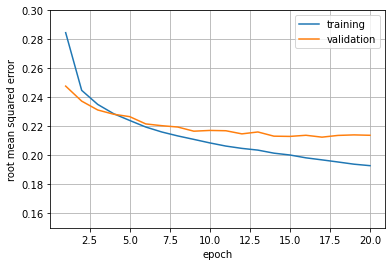

In [24]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.loc[:,:].plot(x='epoch', grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.15,0.3]);

## 학습한 모델로 입력값 분석하기

In [27]:
TEST_DATA_FILE='./data/test.csv'

test = pd.read_csv(TEST_DATA_FILE)

test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [32]:
print(test[:1]["comment_text"])

0    Yo bitch Ja Rule is more succesful then you'll...
Name: comment_text, dtype: object


In [33]:
list_sentences_test = test["comment_text"].fillna("_na_").values # Do the same things for test_data

list_sentences_test[:1]

array(["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"],
      dtype=object)

In [37]:
# Tokenize comment_text
tokenizer = Tokenizer(num_words=max_features) # max_features 만큼의 단어를 Tokenize하기 위한 틀 생성.
                                              # Create a frame to Tokenize words as many as max_features.

list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test) # Tokenize(Transform word into number)

X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # 모든 단어는 각자 다른 길이를 갖고 있으므로 작은 길이의 문장에 
                                                         # padding을 해줌으로서 모든 문장의 길이를 maxlen로 맞춰줌
                                                         # All comment_texts are different in length, 
                                                         # so 0 is filled as much as maxlen in small sentences
            
X_te

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

## 문장 넣어서 입력

In [38]:
input_sentence = "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"


In [39]:
# Tokenize comment_text
tokenizer = Tokenizer(num_words=max_features) # max_features 만큼의 단어를 Tokenize하기 위한 틀 생성.
                                              # Create a frame to Tokenize words as many as max_features.

list_tokenized_test = tokenizer.texts_to_sequences(input_sentence) # Tokenize(Transform word into number)

X_te_ = pad_sequences(list_tokenized_test, maxlen=maxlen) # 모든 단어는 각자 다른 길이를 갖고 있으므로 작은 길이의 문장에 
                                                         # padding을 해줌으로서 모든 문장의 길이를 maxlen로 맞춰줌
                                                         # All comment_texts are different in length, 
                                                         # so 0 is filled as much as maxlen in small sentences
            
X_te_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [40]:
y_test_ = model.predict([X_te_], batch_size=1024, verbose=1) # model에 test data를 넣고 예측
y_test_

1/1 [==============================] - 0s 174ms/step


array([[0.06256434, 0.00492993, 0.02044776, 0.00203806, 0.01044104,
        0.00120094],
       [0.06256434, 0.00492993, 0.02044776, 0.00203806, 0.01044104,
        0.00120094],
       [0.06256434, 0.00492993, 0.02044776, 0.00203806, 0.01044104,
        0.00120094],
       ...,
       [0.06256428, 0.00492987, 0.02044776, 0.00203806, 0.01044104,
        0.00120088],
       [0.06256428, 0.00492987, 0.02044776, 0.00203806, 0.01044104,
        0.00120088],
       [0.06256428, 0.00492993, 0.02044776, 0.00203806, 0.01044104,
        0.00120088]], dtype=float32)

In [46]:
result_of_submission = pd.read_csv('./data/result_of_submission.csv') # 예측값을 저장할 csv파일
result_of_submission[list_classes] = y_test_ # csv에 저장할 값을 설정
result_of_submission.to_csv('./data/submission.csv', index=False) # csv파일에 저장

In [47]:
result_fin = pd.read_csv('./data/submission.csv')
result_fin

,id\ttoxic\tsevere_toxic\tobscene\tthreat\tinsult\tidentity_hate,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
1,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
2,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
3,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
4,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
...,...,...,...,...,...,...,...
362,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
363,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
364,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201
365,NaN,0.062564,0.00493,0.020448,0.002038,0.010441,0.001201


In [48]:
result_val = result_fin.max(axis=1)
result_val

0      0.062564
1      0.062564
2      0.062564
3      0.062564
4      0.062564
         ...   
362    0.062564
363    0.062564
364    0.062564
365    0.062564
366    0.062564
Length: 367, dtype: float64

In [50]:
type(result_val)

pandas.core.series.Series

In [52]:
result_val.mean()

0.0625643427268036

In [49]:
result_val.index = result_fin.idxmax(axis=1)
result_val.index

Index(['toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic',
       'toxic', 'toxic',
       ...
       'toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic', 'toxic',
       'toxic', 'toxic'],
      dtype='object', length=367)

In [51]:
type(result_val.index)

pandas.core.indexes.base.Index

In [55]:
# 추출한 값을 리스트로 만들기
final_result = list(result_val.index)
final_result

['toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',
 'toxic',


In [61]:
from collections import Counter
def most_common(input_list):
    """가장 많이 나오는 값을 추출한다."""
    assert isinstance(input_list, list), 'Must be a list type'
    if len(input_list) == 0: return None
    return Counter(input_list).most_common(n=1)[0][0]

In [62]:
# 최빈값 구하기
most_common(final_result)

'toxic'

## 실행 기능을 하나의 함수로 만들기

In [67]:
from collections import Counter
def most_common(input_list):
    """가장 많이 나오는 값을 추출한다."""
    assert isinstance(input_list, list), 'Must be a list type'
    if len(input_list) == 0: return None
    return Counter(input_list).most_common(n=1)[0][0]

In [68]:
from keras.models import load_model
model = load_model('toxic_model.h5')

In [69]:
def check_comment(input_sent):
    # Tokenize comment_text
    tokenizer = Tokenizer(num_words=max_features) # max_features 만큼의 단어를 Tokenize하기 위한 틀 생성.
                                                  # Create a frame to Tokenize words as many as max_features.

    list_tokenized_test = tokenizer.texts_to_sequences(input_sentence) # Tokenize(Transform word into number)

    X_te_ = pad_sequences(list_tokenized_test, maxlen=maxlen) # 모든 단어는 각자 다른 길이를 갖고 있으므로 작은 길이의 문장에 
                                                             # padding을 해줌으로서 모든 문장의 길이를 maxlen로 맞춰줌
                                                             # All comment_texts are different in length, 
                                                             # so 0 is filled as much as maxlen in small sentences
                
    y_test_ = model.predict([X_te_], batch_size=1024, verbose=1) # model에 test data를 넣고 예측
    
    result_of_submission = pd.read_csv('./data/result_of_submission.csv') # 예측값을 저장할 csv파일
    result_of_submission[list_classes] = y_test_ # csv에 저장할 값을 설정
    result_val = result_of_submission.max(axis=1)
    result_val.mean()
    result_val.index = result_fin.idxmax(axis=1)
    final_result = list(result_val.index)
    # 최빈값 구하기
    result__ = most_common(final_result)
    return result__

In [70]:
input_sentence_test = "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"


In [71]:
re_finfin = check_comment(input_sentence_test)
re_finfin

1/1 [==============================] - 1s 575ms/step


'toxic'